# Setup Imports

In [1]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from userdefinedmodels import *

# Setup Location and Weather

In [2]:
# evaluate hood river, oregon and key west, florida

# latitude, longitude, name, altitude, timezone
hood_river = (45.71417626139969, -121.5154782530592, 'Hood River', 27, 'Etc/GMT+8')

# get Typical Meteorological Year (TMY) data
latitude, longitude, name, altitude, timezone = hood_river
weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0]
weather.index.name = "utc_time"
weather.index = pd.to_datetime(weather.index.to_series().apply(lambda d: d.replace(year=2022)))

location = Location(
    latitude,
    longitude,
    name=name,
    altitude=altitude,
    tz=timezone,
    )

# Setup System

## Module Parameters

In [3]:
# Get the module parameters from the CEC database
MODULE_24 = pvlib.pvsystem.retrieve_sam('CECMod')['JA_Solar_JAM5_L__72_200_SI']

# Copy the paramters we will need to a new dictionary
rich_solar_24V_params = {
    'Name' : 'Rich Solar 24V',
    'Technology': 'monoSI',
    'N_s' : MODULE_24['N_s'],
    'I_sc_ref' : MODULE_24['I_sc_ref'],
    'V_oc_ref' : MODULE_24['V_oc_ref'],
    'I_mp_ref' : MODULE_24['I_mp_ref'],
    'V_mp_ref' : MODULE_24['V_mp_ref'],
    'alpha_sc' : MODULE_24['alpha_sc'],
    'beta_oc' : MODULE_24['beta_oc'],
    'gamma_r' : MODULE_24['gamma_r'],
    'a_ref' : MODULE_24['a_ref'],
    'I_L_ref' : MODULE_24['I_L_ref'],
    'I_o_ref' : MODULE_24['I_o_ref'],
    'R_s' : MODULE_24['R_s'],
    'R_sh_ref' : MODULE_24['R_sh_ref'],
    'Adjust' : MODULE_24['Adjust']
}

## Temperature Parameters

In [4]:
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']


## Inverter Parameters
`v_batt`, `v_start`, `v_continue`, `r_batt_wire`, and `r_pv_wire`, are passed in a dict-like object via the PVSystem kwarg `inverter_parameters`.  

In [5]:
# Assume 20 ft of 10AGW wire on PV Side
r_batt_wire = getWireResistance('10AWG', 20)
# Assume 10 ft 10AGW wire on Battery Side
r_pv_wire = getWireResistance('10AWG', 10)

mppt_parameters = {
    'v_batt': 14.2,
    'v_start': 5.0,
    'v_continue': 1.0,
    'r_batt_wire': r_batt_wire,
    'r_pv_wire': r_pv_wire,
    'mppt_eff': 0.99
}

## Array Loss Parameters

In [6]:
#array_loss_parameters = {'dc_ohmic_percent': 0.1}
#test
#array_loss_parameters = {'r_pv_wire': 0.1}

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: functools.partial(<function mppt at 0xffff3e5c60c0>, ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: ...
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses)
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses
Energy (KW-hr)=
 259.3066771542272


<Axes: title={'center': 'MPPT Loss (W)'}, xlabel='utc_time'>

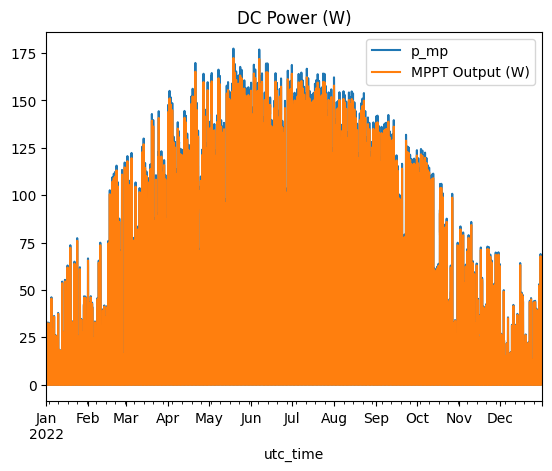

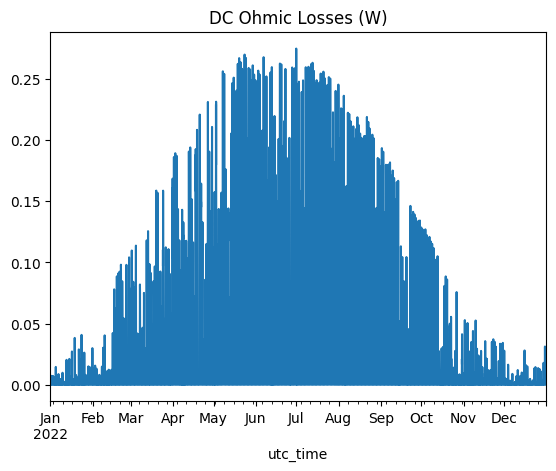

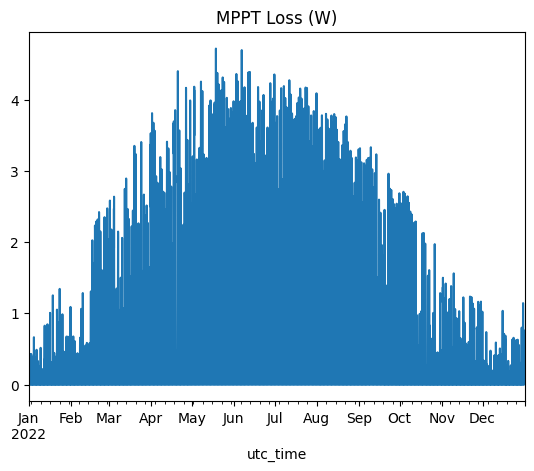

In [7]:

mount = FixedMount(
    surface_tilt=0,
    surface_azimuth=180,
    )
array = Array(
    mount=mount,
    module_parameters=rich_solar_24V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=1,
    modules_per_string=1,
    )

system = PVSystem(arrays=[array], 
                  inverter_parameters=mppt_parameters)

mc = ModelChain(system, 
                location, 
                aoi_model="physical", 
                spectral_model="no_loss", 
                dc_model="cec",
                ac_model=mppt,
                dc_ohmic_model=pv_wire_loss
                )

# print the model chain
print(mc)

mc.run_model(weather)
    
#plot
plt.figure()
mc.results.dc['p_mp'].plot(title='DC Power (W)')
mc.results.ac.plot(label='MPPT Output (W)')
plt.legend()
energy = mc.results.ac.sum()/1000

#plot
plt.figure()
mc.results.dc_ohmic_losses['p_pv_wire_loss'].plot(title='DC Ohmic Losses (W)')
print('Energy (KW-hr)=\n', energy)

plt.figure()
(mc.results.dc['p_mp'] - mc.results.dc_ohmic_losses['p_pv_wire_loss'] - mc.results.ac).plot(title='MPPT Loss (W)')

Now lets figure out what results.dc really is

results.dc=
<class 'pandas.core.frame.DataFrame'>
                                   i_sc       v_oc          i_mp       v_mp  \
utc_time                                                                      
2022-01-01 00:00:00+00:00  1.471018e-01  42.322199  1.390390e-01  36.687617   
2022-01-01 01:00:00+00:00  0.000000e+00   0.000000  0.000000e+00   0.000000   
2022-01-01 02:00:00+00:00  1.615587e-27   0.000000  1.615587e-27   0.000000   
2022-01-01 03:00:00+00:00 -3.231174e-27   0.000000 -3.231174e-27   0.000000   
2022-01-01 04:00:00+00:00  3.231174e-27   0.000000  3.231174e-27   0.000000   
...                                 ...        ...           ...        ...   
2022-12-31 19:00:00+00:00  1.160762e+00  45.920761  1.099615e+00  39.685349   
2022-12-31 20:00:00+00:00  1.362503e+00  45.839468  1.289958e+00  39.494668   
2022-12-31 21:00:00+00:00  1.203287e+00  45.595536  1.139124e+00  39.327834   
2022-12-31 22:00:00+00:00  1.332294e+00  45.342802  1.260294e+00  38.999896   
20

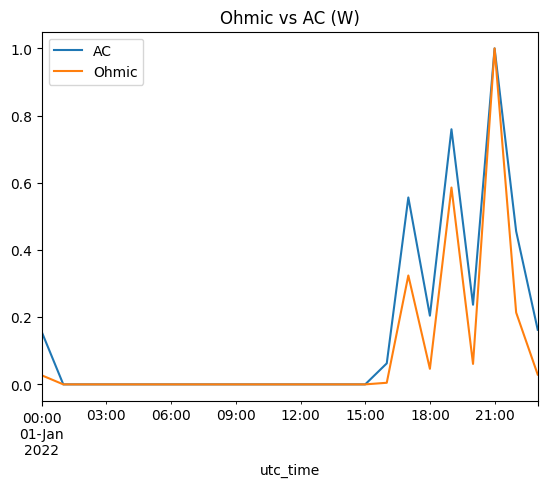

In [8]:
print('results.dc=')
print(type(mc.results.dc))
print(mc.results.dc)

print("results.dc['p_mp']=")
print(type(mc.results.dc['p_mp']))
print(mc.results.dc['p_mp'])    

print('results.ac=')
print(type(mc.results.ac))
print(mc.results.ac)

print('results.dc_ohmic_losses=')
print(type(mc.results.dc_ohmic_losses))
print(mc.results.dc_ohmic_losses)

print('ohmic vs ac=')
ohmic_vs_ac = pd.concat([mc.results.dc_ohmic_losses['p_pv_wire_loss'],
                         mc.results.dc_ohmic_losses['v_pv_wire_drop'],
                         mc.results.ac], axis=1)
print(ohmic_vs_ac)
#plot the first 24 hour period of ohmic vs ac
plt.figure()
ohmic_vs_ac['p_ac'].iloc[:24].div(ohmic_vs_ac['p_ac'].iloc[:24].max()).plot(title='Ohmic vs AC (W)', label='AC')
ohmic_vs_ac['p_pv_wire_loss'].iloc[:24].div(ohmic_vs_ac['p_pv_wire_loss'].iloc[:24].max()).plot(label='Ohmic')
plt.legend()

print(ohmic_vs_ac.iloc[:24])

In [9]:
a = [1, 2, 3, 4, 5]
b = [1, 2, 3, 4, 5]
points = a, b

print('points=', points)

points= ([1, 2, 3, 4, 5], [1, 2, 3, 4, 5])


In [10]:
inverter_params = {}
    # Defaulting parameters if not explicitly provided
mppt_eff = inverter_params.get('mppt_eff', 1.0)
r_batt_wire = inverter_params.get('r_batt_wire', 0)

print('mppt_eff=', mppt_eff)

mppt_eff= 1.0


In [11]:
def calculate_i_out(p_mppt_out):
    v_batt = 14.2 # volts
    r_batt_wire = 0.001 # ohms
    if r_batt_wire == 0:
        return p_mppt_out/v_batt
    else:
        return (-1*v_batt + np.sqrt(v_batt**2 + 4*p_mppt_out*r_batt_wire))/(2*r_batt_wire)
    
print('calculate_i_out(200)=', calculate_i_out(200))

calculate_i_out(200)= 14.070564732964641
